### Application of $\chi^2$ on ASCAD

On a per-sample-point basis.

In [43]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from tools.nbloader import NotebookLoader

from tools.traceloader import ASCAD, TraceGroup

sns.set_style("whitegrid")

KEY_SIZE = 256
TRACE_LEN = 700

In [44]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(50000, 700)

In [45]:
chi_squared = NotebookLoader(["../tvla"]).load_module("chi2").chi_squared

importing Jupyter notebook from ../tvla/chi2.ipynb


In [46]:
def v_count(traces, offset=-.5, trace_range=KEY_SIZE):
    traces = np.moveaxis(traces, 0, -1)
    pos_traces = traces + round(-trace_range * offset)

    return [np.bincount(t, minlength=trace_range) for t in pos_traces]

In [47]:
def chi_sample_point(tg: TraceGroup, ks=KEY_SIZE):
    counts_prof = [v_count(tg.profile.filter_traces(i)) for i in range(ks)]
    counts_att = [v_count(tg.attack.filter_traces(i)) * 2 for i in range(ks)]

    csp = np.array([[np.zeros(TRACE_LEN)] * ks] * ks)
    for i in tqdm(range(ks)):
        for j in range(ks):
            csp[i][j] = [chi_squared(counts_prof[i][ix], counts_att[j][ix]) for ix in range(TRACE_LEN)]

    return csp

CSP = chi_sample_point(ascad.default, 20)

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


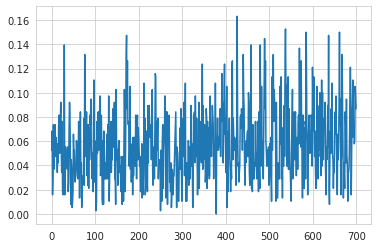

In [48]:
def csp_plot(csp):
    nk = csp.shape[0]

    neq = np.array(np.ones([nk] * 2) - np.identity(nk), dtype=bool)
    eq = np.array(np.identity(nk), dtype=bool)

    sum_eq = np.mean(np.less(csp[eq], .05), axis=0)
    sum_neq = np.mean(np.less(csp[neq], .05), axis=0)
    sns.lineplot(data=(sum_neq))

csp_plot(CSP)